# Fase 1: Preparación de los datos

## Importación de Librerías y Configuración

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import shuffle

# Para Deep Learning (LSTM)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical

# Configuración visual
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

print("Librerías importadas correctamente.")

Librerías importadas correctamente.


## Carga de Datos

Lee los archivos csv que han sido generados previamente con el script generate_mappings.

In [2]:
def load_tep_data(fault_range=range(0, 22), data_dir='../data/TEP_csv'):
    train_data = []
    test_data = []
    
    print("Cargando datos...")
    
    for fault_id in fault_range:
        file_id = f"{fault_id:02d}"
        train_file = f"d{file_id}.csv"
        test_file = f"d{file_id}_te.csv"
        
        path_train = os.path.join(data_dir, train_file)
        path_test = os.path.join(data_dir, test_file)
        
        if os.path.exists(path_train):
            df_tr = pd.read_csv(path_train)
            train_data.append(df_tr)
            
        if os.path.exists(path_test):
            df_te = pd.read_csv(path_test)
            test_data.append(df_te)
    
    df_train_final = pd.concat(train_data, ignore_index=True)
    df_test_final = pd.concat(test_data, ignore_index=True)
    
    return df_train_final, df_test_final

# Cargar datos
df_train, df_test = load_tep_data()

print("Columnas disponibles:", df_train.columns.tolist())
print("Total columnas:", len(df_train.columns))



Cargando datos...
Columnas disponibles: ['A_Feed_stream1', 'D_Feed_stream2', 'E_Feed_stream3', 'AC_Feed_stream4', 'Recycle_Flow_stream8', 'Reactor_Feed_Rate_stream6', 'Reactor_Pressure', 'Reactor_Level', 'Reactor_Temperature', 'Purge_Rate_stream9', 'Product_Sep_Temp', 'Product_Sep_Level', 'Prod_Sep_Pressure', 'Prod_Sep_Underflow_stream10', 'Stripper_Level', 'Stripper_Pressure', 'Stripper_Underflow_stream11', 'Stripper_Temperature', 'Stripper_Steam_Flow', 'Compressor_Work', 'Reactor_CW_Outlet_Temp', 'Separator_CW_Outlet_Temp', 'Reactor_Feed_CompA', 'Reactor_Feed_CompB', 'Reactor_Feed_CompC', 'Reactor_Feed_CompD', 'Reactor_Feed_CompE', 'Reactor_Feed_CompF', 'Purge_Gas_CompA', 'Purge_Gas_CompB', 'Purge_Gas_CompC', 'Purge_Gas_CompD', 'Purge_Gas_CompE', 'Purge_Gas_CompF', 'Purge_Gas_CompG', 'Purge_Gas_CompH', 'Product_CompD', 'Product_CompE', 'Product_CompF', 'Product_CompG', 'Product_CompH', 'D_Feed_Flow', 'E_Feed_Flow', 'A_Feed_Flow', 'AC_Feed_Flow', 'Compressor_Recycle_Valve', 'Purge_Val

## Exploración inicial

In [3]:
print("\nInformación del dataset:")
print("Train:")
print(df_train.info())
print("\nTest:")
print(df_test.info())

print("\nPrimeras 5 filas del dataset (train):")
print(df_train.head())


print("\nDistribución de fallos (Train):")
fault_dist_train = df_train['fault'].value_counts().sort_index()
print(fault_dist_train)

print("\nDistribución de fallos (Test):")
fault_dist_test = df_test['fault'].value_counts().sort_index()
print(fault_dist_test)

# Verificar si hay valores nulos
print("\nValores nulos:")
print(f"Train: {df_train.isnull().sum().sum()} nulos")
print(f"Test:  {df_test.isnull().sum().sum()} nulos")


Información del dataset:
Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10580 entries, 0 to 10579
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   A_Feed_stream1               10580 non-null  float64
 1   D_Feed_stream2               10580 non-null  float64
 2   E_Feed_stream3               10580 non-null  float64
 3   AC_Feed_stream4              10580 non-null  float64
 4   Recycle_Flow_stream8         10580 non-null  float64
 5   Reactor_Feed_Rate_stream6    10580 non-null  float64
 6   Reactor_Pressure             10580 non-null  float64
 7   Reactor_Level                10580 non-null  float64
 8   Reactor_Temperature          10580 non-null  float64
 9   Purge_Rate_stream9           10580 non-null  float64
 10  Product_Sep_Temp             10580 non-null  float64
 11  Product_Sep_Level            10580 non-null  float64
 12  Prod_Sep_Pressure            10580 non-nu

Los datos en el conjunto de train están correctamente balanceados ya que no se observan diferencias grandes entre clases. Sin embargo, el dataset de train contiene 500 muestras de funcionamiento normal y 480 muestras por cada uno de los 21 fallos. Esto quiere decir que el modelo aprende que "casi siempre hay un fallo", por lo que le costará mucho aprender a identificar cuando no hay problemsas.

## Limpieza y Normalización

In [4]:
# Eliminar columnas irrelevantes
columns_to_drop = ['sample', 'fault', 'fault_type']
# Asegurarnos de que existan antes de borrarlas
cols_train = [c for c in columns_to_drop if c in df_train.columns]
cols_test = [c for c in columns_to_drop if c in df_test.columns]

X_train = df_train.drop(cols_train, axis=1)
y_train = df_train['fault']
X_test = df_test.drop(cols_test, axis=1)
y_test = df_test['fault']

# Normalización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Guardar scaler para utilizarlo en la aplicación final
joblib.dump(scaler, 'tep_scaler.pkl')
print("Datos normalizados y Scaler guardado.")

Datos normalizados y Scaler guardado.


## Selección de variables

/var/folders/ql/chdr3tpx7pz4ftr0xxsf1sd80000gn/T/ipykernel_63542/1832385260.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')


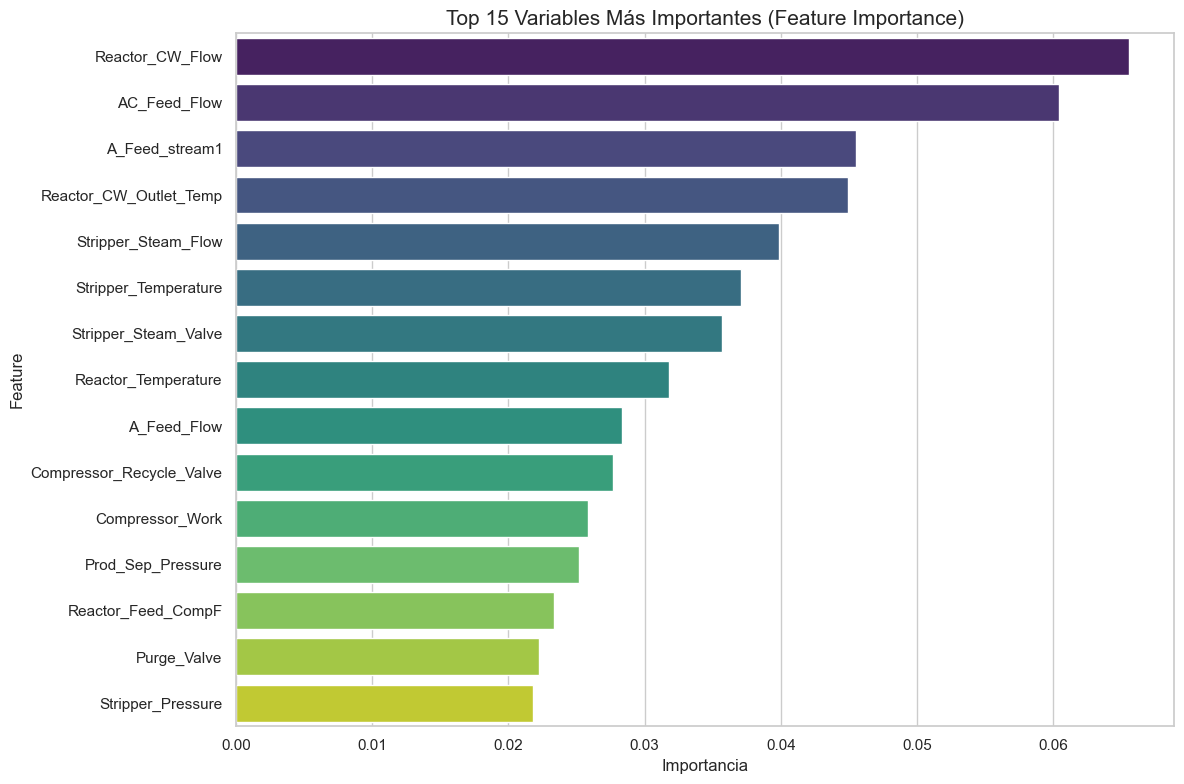

Las 5 variables más críticas son: ['Reactor_CW_Flow', 'AC_Feed_Flow', 'A_Feed_stream1', 'Reactor_CW_Outlet_Temp', 'Stripper_Steam_Flow']


In [5]:
# Usamos Random Forest para identificar las variables más importantes
rf_selector = RandomForestClassifier(n_estimators=50, random_state=42, n_jobs=-1)
rf_selector.fit(X_train_scaled, y_train)

# Crear DataFrame de importancia
importances = rf_selector.feature_importances_
feature_names = X_train.columns
feature_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_imp_df = feature_imp_df.sort_values(by='Importance', ascending=False).head(15)

# Visualización
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_imp_df, palette='viridis')
plt.title('Top 15 Variables Más Importantes (Feature Importance)', fontsize=15)
plt.xlabel('Importancia')
plt.tight_layout()
plt.show()

top_features_list = feature_imp_df['Feature'].tolist()
print("Las 5 variables más críticas son:", top_features_list[:5])

## Visualizacion Temporal

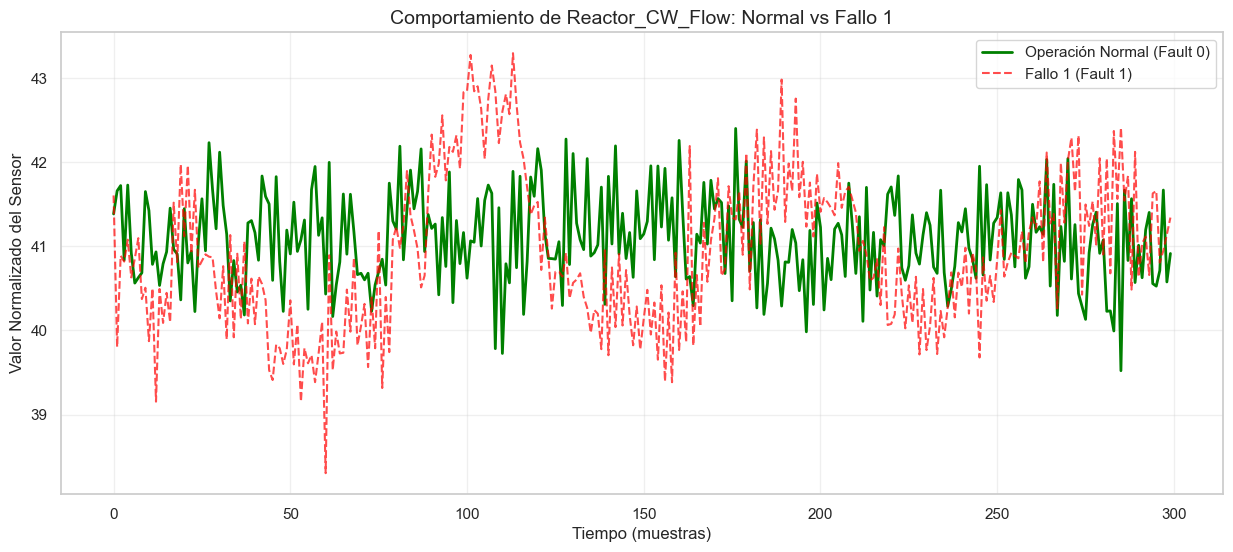

In [6]:
# Tomamos la variable más importante del análisis anterior
top_feature = feature_imp_df.iloc[0]['Feature'] 

plt.figure(figsize=(15, 6))

# 1. Tramo de operación Normal
normal_data = df_test[df_test['fault'] == 0][top_feature].values[:300]
plt.plot(normal_data, label='Operación Normal (Fault 0)', color='green', linewidth=2)

# 2. Tramo de un Fallo (ej: Fallo 1)
fault_data = df_test[df_test['fault'] == 1][top_feature].values[:300]
plt.plot(fault_data, label='Fallo 1 (Fault 1)', color='red', linestyle='--', alpha=0.7)

plt.title(f'Comportamiento de {top_feature}: Normal vs Fallo 1', fontsize=14)
plt.xlabel('Tiempo (muestras)')
plt.ylabel('Valor Normalizado del Sensor')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

El comportamiento bajo fallo parece más inestable, la línea roja tiene picos y caídas más abruptas. La variabilidad visual es mayor, sugiriendo un incremento en la intermitencia o ruido en el sistema.

## Preparación para LSTM (Secuencias)

In [7]:
def create_sequences(X, y, time_steps=10):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

TIME_STEPS = 10 

X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train.values, TIME_STEPS)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test.values, TIME_STEPS)

# One-hot encoding
num_classes = len(np.unique(y_train))
y_train_lstm_cat = to_categorical(y_train_lstm, num_classes=num_classes)
y_test_lstm_cat = to_categorical(y_test_lstm, num_classes=num_classes)

print("Shape LSTM Train:", X_train_lstm.shape)

Shape LSTM Train: (10570, 10, 52)


## Entrenamiento de Modelos y Comparativa

### Modelo 1: Random Forest con optimización de hiperparámetros

In [8]:
from sklearn.model_selection import GridSearchCV

print("Optimizando hiperparámetros con GridSearchCV...")

# Definir grid de parámetros
param_grid = {
    'n_estimators': [200, 300, 500],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

# Crear modelo base
rf_base = RandomForestClassifier(
    random_state=42,
    n_jobs=-1,
    class_weight='balanced'
)

# GridSearch con validación cruzada
grid_search = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid,
    cv=3,                    # 3-fold cross-validation
    scoring='f1_weighted',   # Métrica de optimización
    verbose=2,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)

# Mejor modelo
rf_model = grid_search.best_estimator_
print(f"\nMejores parámetros: {grid_search.best_params_}")
print(f"Mejor F1-Score (CV): {grid_search.best_score_:.4f}")

# Evaluar
y_pred_rf = rf_model.predict(X_test_scaled)
print("\n--- Reporte Random Forest Optimizado ---")
print(classification_report(y_test, y_pred_rf))
joblib.dump(rf_model, 'tep_rf_model_optimized.pkl')

Optimizando hiperparámetros con GridSearchCV...
Fitting 3 folds for each of 162 candidates, totalling 486 fits
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.2s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.7s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   8.9s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  12.4s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.3s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=300; total time=  13.6s
[CV] END max_depth=15, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   8.9s
[CV] END max_depth=15, max_features=sqrt, min_sam

['tep_rf_model_optimized.pkl']

### Modelo 2: LSTM

In [9]:
from sklearn.utils import shuffle
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization

X_train_lstm, y_train_lstm_cat = shuffle(X_train_lstm, y_train_lstm_cat, random_state=42)

print("Entrenando LSTM...")

model_lstm = Sequential()

# 1. Primera capa LSTM: Más neuronas y 'return_sequences=True' para conectar con otra LSTM
model_lstm.add(LSTM(128, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2]), return_sequences=True))
model_lstm.add(BatchNormalization()) # Estabiliza el aprendizaje
model_lstm.add(Dropout(0.3))         # Evita memorización pura

# 2. Segunda capa LSTM: Procesa lo que entendió la primera capa
model_lstm.add(LSTM(64, return_sequences=False))
model_lstm.add(BatchNormalization())
model_lstm.add(Dropout(0.3))

# 3. Capa Densa Intermedia: Para procesar características antes de clasificar
model_lstm.add(Dense(64, activation='relu'))

# 4. Capa de Salida: 22 neuronas (una por clase)
model_lstm.add(Dense(num_classes, activation='softmax'))

# Compilación
model_lstm.compile(optimizer='adam', 
                   loss='categorical_crossentropy', 
                   metrics=['accuracy'])

# --- CALLBACKS: La clave para que no se estanque ---
callbacks = [
    # Si la val_loss no mejora en 10 epochs, para y quédate con el mejor modelo
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1),
    
    # Si se estanca 3 epochs, reduce la velocidad de aprendizaje a la mitad
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
]

# Entrenamiento
history = model_lstm.fit(
    X_train_lstm, y_train_lstm_cat,
    epochs=50,  
    batch_size=64,
    validation_split=0.2, # Usamos 20% para validar (estándar)
    callbacks=callbacks,  # Añadimos los callbacks
    verbose=1
)

model_lstm.save('tep_lstm_model.keras')
print("Modelo LSTM Mejorado guardado.")

Entrenando LSTM...
Epoch 1/50


/Users/sara/Documents/deusto_2025_2026/Analítica de Datos para la Industria/ProyectoFinal_Grupo03/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


133/133 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.4523 - loss: 1.9153 - val_accuracy: 0.6561 - val_loss: 1.7023 - learning_rate: 0.0010
Epoch 2/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.7241 - loss: 0.9380 - val_accuracy: 0.7569 - val_loss: 0.8172 - learning_rate: 0.0010
Epoch 3/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7909 - loss: 0.6584 - val_accuracy: 0.8415 - val_loss: 0.4958 - learning_rate: 0.0010
Epoch 4/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8310 - loss: 0.5086 - val_accuracy: 0.8671 - val_loss: 0.3817 - learning_rate: 0.0010
Epoch 5/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8625 - loss: 0.4171 - val_accuracy: 0.9054 - val_loss: 0.2723 - learning_rate: 0.0010
Epoch 6/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9001 - loss: 0.3131 - val_accuracy: 0.9451 - val_loss: 0.1783 - learning_rate: 0.0010
Epoch 7/50
133/133 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.9111 - loss: 0.2715 - val_

## Evaluación y Matriz de Confusión

660/660 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


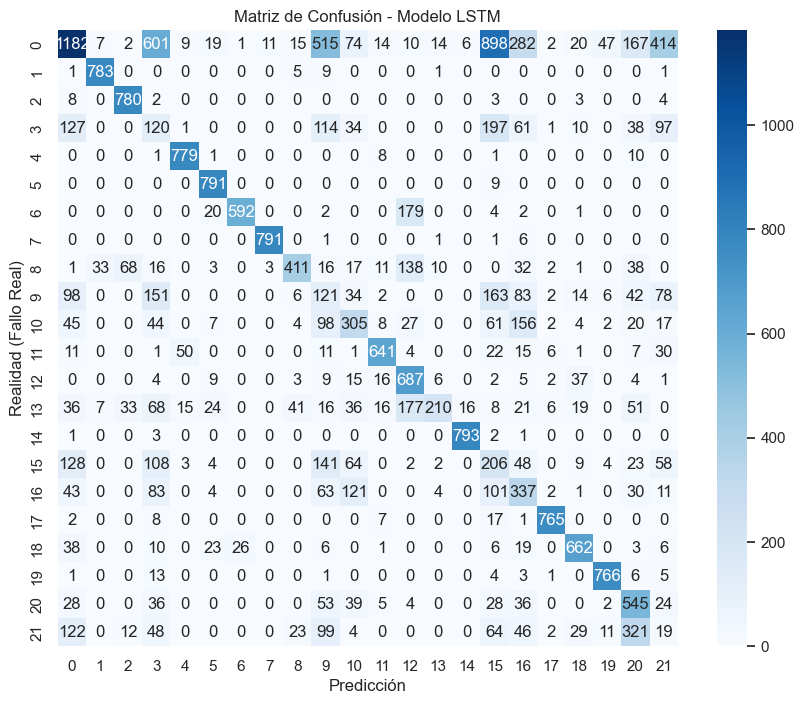

F1-Score Random Forest: 0.5976
F1-Score LSTM: 0.5891


In [10]:
# Predicciones LSTM
y_pred_lstm_prob = model_lstm.predict(X_test_lstm)
y_pred_lstm = np.argmax(y_pred_lstm_prob, axis=1)

# Matriz de Confusión (Usando LSTM como ejemplo principal)
cm = confusion_matrix(y_test_lstm, y_pred_lstm)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matriz de Confusión - Modelo LSTM")
plt.xlabel("Predicción")
plt.ylabel("Realidad (Fallo Real)")
plt.show()

# Comparativa rápida
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')
f1_lstm = f1_score(y_test_lstm, y_pred_lstm, average='weighted')

print(f"F1-Score Random Forest: {f1_rf:.4f}")
print(f"F1-Score LSTM: {f1_lstm:.4f}")

## Guardar datos procesados

In [11]:
# Crear carpeta para datos procesados
os.makedirs('../data/processed', exist_ok=True)

# Guardar datos escalados como CSV
pd.DataFrame(X_train_scaled, columns=X_train.columns).to_csv('../data/processed/X_train_scaled.csv', index=False)
pd.DataFrame(X_test_scaled, columns=X_test.columns).to_csv('../data/processed/X_test_scaled.csv', index=False)
y_train.to_csv('../data/processed/y_train.csv', index=False)
y_test.to_csv('../data/processed/y_test.csv', index=False)

print("✓ Datos escalados guardados en ../data/processed/")

✓ Datos escalados guardados en ../data/processed/
